## [**Everything you did and didn't know about PCA**](http://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/)

# Contents
- [Intro](#Intro)
- [Notation](#Notation).
- [Everything you did know or (do now)](#Everything)
- [An alternative optimization problem](#An-alternative-optimization-problem)
- [Generalizations of PCA: sparse features, loss functions](#Generalizations-of-PCA:-sparse-features,-loss-functions)
- [Some things you maybe didn't know about PCA](#some-things)
- [TL;DR](#TL;DR)
- [Further Reading](#Further-Reading)

[How to create contents of table in Markdown](https://www.eddymens.com/blog/markdown-table-of-contents-toc-how-to-create-one)

<a id = "Intro"></a>
## **Introduction**
Many scientists are familiar with organizing and handling data in 2D tables. For example, we might record the mRNA expression level of $p$
 genes in $n \times p$ tissue samples. We might store these data in a 
 matrix, where each row corresponds to a sample, and each column corresponds to a gene. Principle components analysis (PCA) is a standard way to reduce the dimension $p$ (which can be quite large) to something more manageable.

 While it is quite common for biologists to apply PCA to their data, it is less common for them to really understand the mechanics and assumptions implicit in this analysis. Opening up the black box on a statistical technique is worthwhile in and of itself, but the real reason I’m motivated to write this is the number of seriously cool and super useful extensions/variations of PCA (e.g., Non-negative matrix factorization, Sparse PCA, Tensor Decompositions), which will have a growing impact on modern neuroscience and biology. I want to blog about techniques of this flavor for the next few posts.

 If you are completely unfamiliar with PCA, there are some great explanations online that you should reference concurrently with reading this post. While these materials are quite good, many of them don’t explain PCA in a way that naturally lends itself to more complex (but fun and useful!) extensions.

 I aimed to be as pedagogical as possible in this post, but you will need to be familiar with some linear algebra to follow along. You don’t need to know what an eigenvalue is (though it will help you understand certain results more deeply), but basic matrix operations are needed. Also, go teach yourself what an eigenvalue is, it’s good for you.
 
 If you think you’re already a PCA whiz and don’t care for the background stuff, you can skip to some things you maybe didn’t know about PCA or just read the tl;dr.

<a id = "Notation"></a>
## **Notation**
- Boldface capital letters = matrices (e.g. $X$)
- Boldface lowercase letters = column vectors (e.g. $u$)
- Non-boldface letters = scalars (e.g. $i$, $j$, $I$, $J$, $x_{ij}$)
- Note that scalars are often lowercase, but can be uppercase
- Superscript $T$ = transpose operator (e.g. $c^T$, $X^T$)
- Subscripts = element position (e.g. $x_{ij}$ is the scalar in row $i$ column $j$ of the matrix $X$)

Throughout, we suppose that we have a matrix of data $X$ with dimensions $I \times J$, where $I$ is the number of observations, and $J$ is the number of features that are measured and associated with each observation. For example, we might record $I$ neurons and estimate their firing rate at $J$ timepoints; or we might measure the expression of $J$ genes across $I$ cells.

We index into $X$ using a lowercase index variable, i.e., $x_{ij}$ where $i$ and $j$ respectively range from $1$ to $I$ and $1$ to $J$.

<a id = "Everything"></a>
## **Everything you did know (or do now)**

PCA tries to find “components” that capture the maximal variance within the data. For three dimensional data, this is the basic image you may have come across:

<center> <p>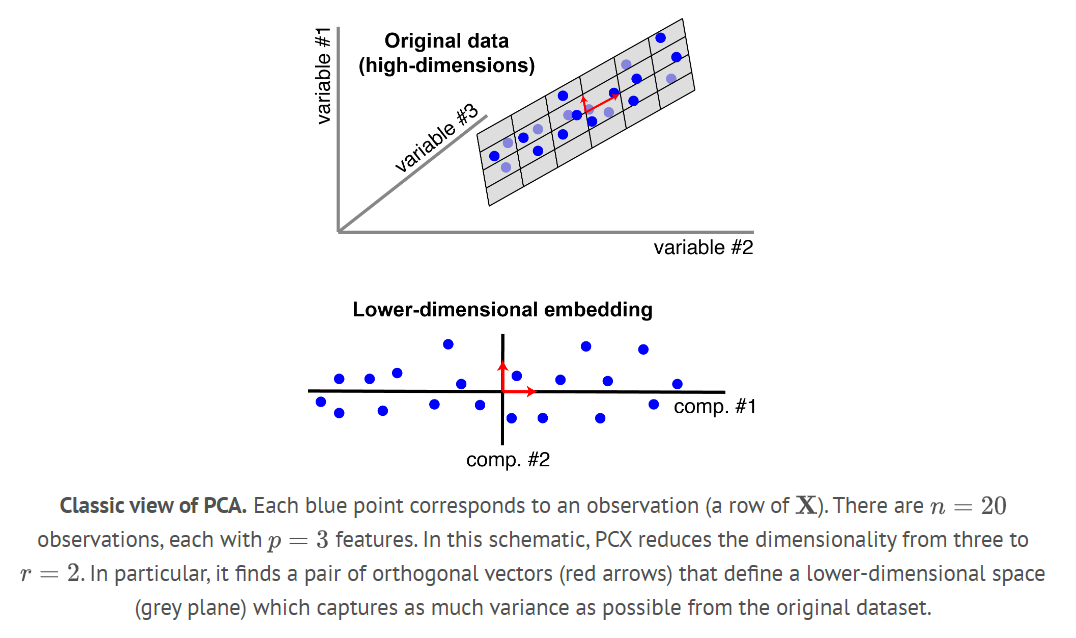</p> </center>

Now let’s express the above picture mathematically. Assume that each column of $X$ has been mean subtracted so that the datapoints are centered around the origin. Then finding the direction of maximal variance (i.e. the first principal component) corresponds to solving the following optimization problem

\begin{equation}
\begin{aligned}
& \underset{\mathbf{c}}{\text{maximize}}
& & \mathbf{c}^T \mathbf{X}^T \mathbf{X} \mathbf{c} \\
& \text{subject to}
& & \mathbf{c}^T \mathbf{c} = 1
\end{aligned}
\end{equation}

Why does $c^T X^T X c$ measure the variance we want to maximize? Let $w = Xc$, which is the projection of each datapoint onto the top principal component (since we imposed $c^T c = 1$). Because the data have been mean subtracted, the variance of the projected data is $w^T w$, which equals the objective function $c^T X^T X c$.[1] The vector $c$ is the top principal component, and the vector $w$ contains the “loadings” for each observation along this axis.

There are a few ways to solve this optimization problem to determine $c$ and $w$. The classic approach would be to compute the eigenvalues of $X^T X$ (the covariance matrix with dimensions $p \times p$) and set $c$ to the eigenvector associated with the largest eigenvalue.[2] This is more-or-less what happens under the hood when you call pca() in MATLAB or python — the eigendecomposition of the covariance matrix is computed via the singular value decomposition (SVD). <span style="color:red">It turns out that this approach does not work for tensors, matrices with incomplete data, or many other interesting cases.</span>

Let’s assume that we solve the optimization problem (1) by some method. Then our best approximation of the data is the outer product of $w$ and $c$:

$$
\mathbf{X} \approx \mathbf{w} \mathbf{c}^T \quad \text{or} \quad  x_{ij} \approx w_i c_j
$$

This is called a rank-one reconstruction of the data because $w c^T$ produces a matrix with rank=1 (click here for explanation of matrix rank). Visually, our reconstruction looks something like this:

<center> <p>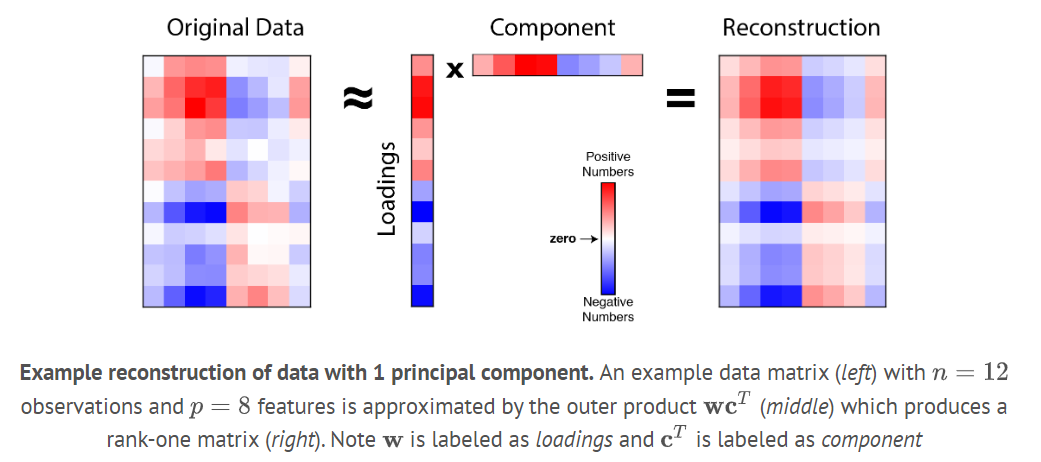</p> </center>

Most data can’t be well-described by a single principal component. Typically, we compute multiple principal components by computing all eigenvectors of $X^T X$ and ranking them by their eigenvalues. This can be visualized by a scree plot, which plots the variance explained by each successive principal component. People may have told you to look for the “knee” or inflection point in the scree plot to determine the number of components to keep (the rest are noise). **_Spoiler alert_**: *you can do better than this, and we’ll see how by the end of the post.*

<center> <p>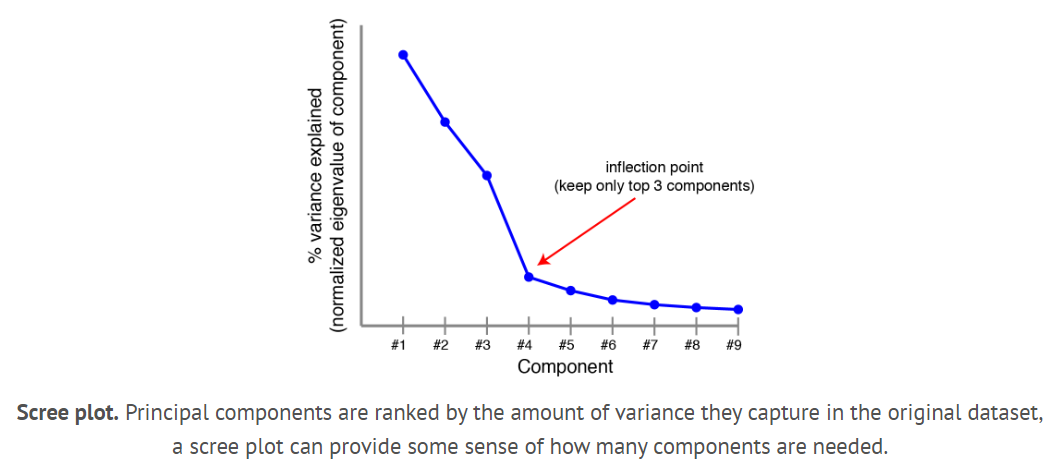</p> </center>

We can organize the top $r$ principal components into a matrix $C = [ \mathbf{c}_1, \mathbf{c}_2, … , \mathbf{c}_r ]$
 and the loading weights into $W = [ \mathbf{w}_1, \mathbf{w}_2, … , \mathbf{w}_r ]$. Our reconstruction of the data is now a sum of $r$
 outer products:
 $$
 \mathbf{X} \approx \sum_{k=1}^r \mathbf{w}_k \mathbf{c}_k^T \quad \text{or} \quad \mathbf{X} \approx W C^T
 $$

<center> <p>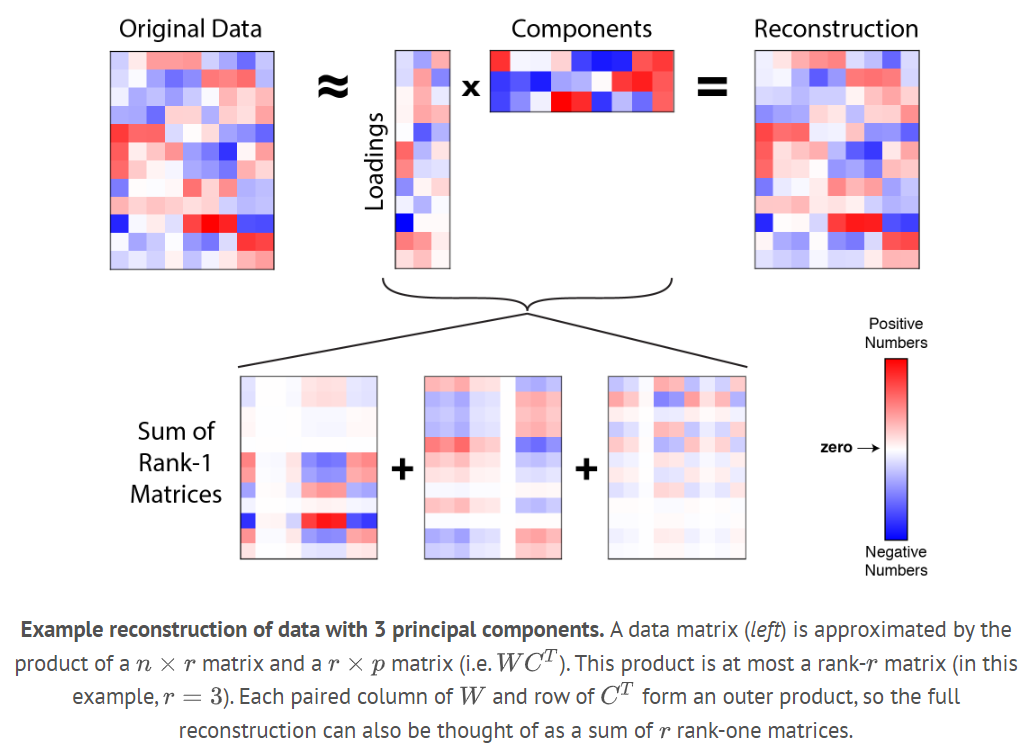</p> </center>

Each row of the components matrix, $C^T$, is a principal component, which is a mixture of the $p$ features measured in the dataset. Each row of the loadings matrix, $W$, provides a recipe for combining the 
 components to approximately reconstruct a single datapoint (i.e. a row in $X$). For example, if row $i$ of $W$ was $[1, 2, -1]$, then our estimate for row $i$ of $X$ would be: $\mathbf{c}_1 + 2 \mathbf{c}_2 - \mathbf{c}_3$ where the $c$’s are the top three components (the rows of $C^T$). That is, our reconstruction for the data at row $i$, column $j$ is simply a linear combination of the components:
 $$
 x_{ij} \approx \sum_{k=1}^r W_{ik} C_{jk}
 $$

## **An alternative optimization problem**
As discussed above, a classic perspective is that PCA finds a set of directions (technically, a linear subspace) that maximizes the variance of the data once it is projected into that space. It turns out that this is equivalent to finding a linear subspace that minimizes the distance of the projection in a least-squares sense.[3]

<center> <p>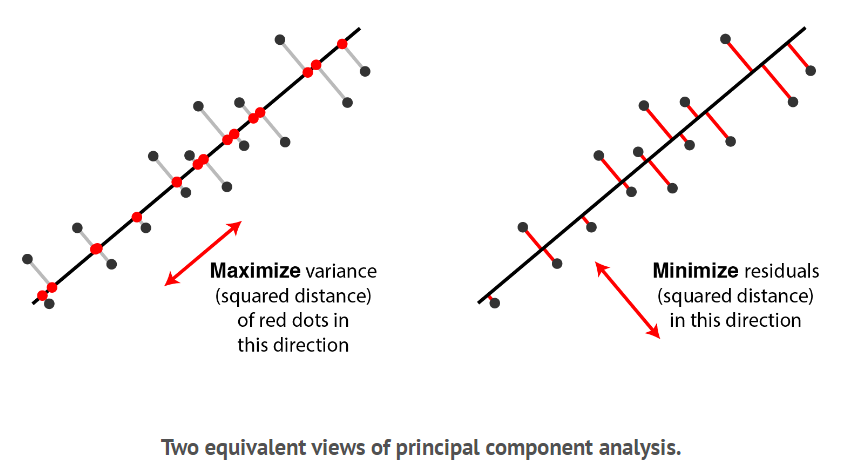</p> </center>

In this second perspective on PCA, we can find the top $r$ principal components $C$ by solving:

\begin{equation}
\begin{aligned}
& \underset{C}{\text{minimize}}
& & \lVert \mathbf{X} - \mathbf{X} C C^T \lVert_F^2 \\
& \text{subject to}
& & C^T C = I
\end{aligned}
\end{equation}

As before, the loadings are a $n \times r$ matrix holding the projected data ($W=XC$), our reconstruction is a rank-$r$ matrix ($\mathbf{X} \approx \mathbf{X} C C^T = W C^T$). Above, $\lVert \cdot \lVert_F^2$
 denotes the squared Frobenius norm, which sounds fancy,[4] but it is just the sum of squared residuals:

 $$
 \lVert \mathbf{X} - W C^T \lVert_F^2 = \sum_{i=1}^n \sum_{j=1}^p (x_{ij} - \sum_{k=1}^K W_{ik} C_{jk})^2
 $$

 Why is minimizing squared residuals equivalent to maximizing variance? Consider a datapoint $a_i$ (row $i$ of $X$). Then the contribution of that datapoint to the variance is $\mathbf{a}_i^T \mathbf{a}_i$, or equivalently the squared Euclidean length $\lVert \mathbf{a}_i \lVert^2_2$. Applying the Pythagorean theorem shows that this total variance equals the sum of variance lost (the squared residual) and variance remaining. Thus, <span style="color:lightblue">it is equivalent to either maximize remaining variance or minimize lost variance to find the principal components.</span> The figure below visualizes this for 2 dimensions:

<center> <p>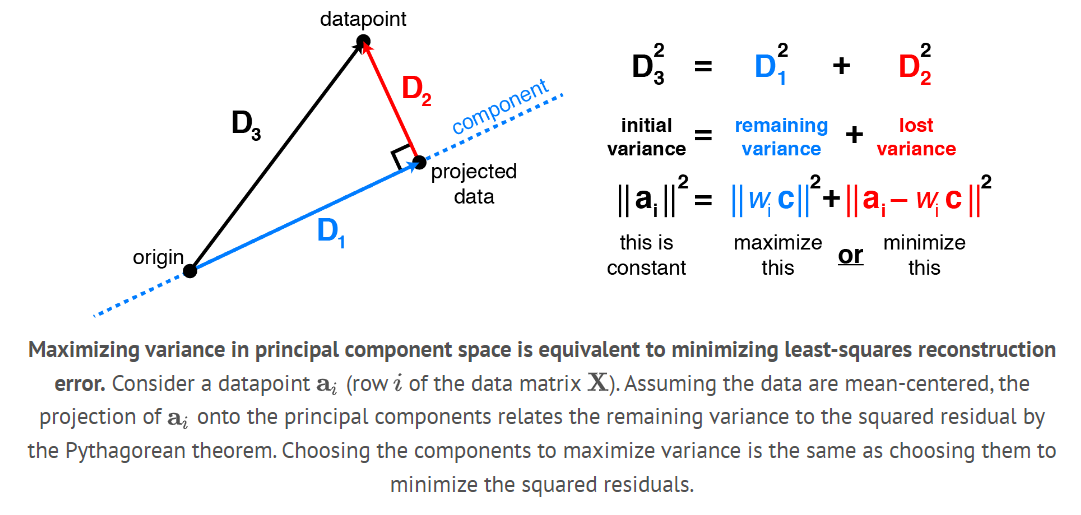</p> </center>

## **Generalizations of PCA: sparse features, loss functions**
Thinking about PCA as minimizing reconstruction error is useful because it draws a connection to statistical regression.[5] Simple least-squares linear regression has been extended and adapted to a wide variety of statistical problems (see GLMs), and we can leverage this research framework and perspective to come up with more specialized versions of PCA. This general framework has been developed my a number of papers (Collins, 2001; Gordon, 2004; Udell, 2015). Below is a whirlwind tour:

We will start with **quadratically regularized PCA**, which is similar to ridge regression. The basic idea is to penalize the squared Euclidean length (L2 norm) of the rows of $W$ and $C$ so that they don’t get too large:

\begin{equation}
\begin{aligned}
& \underset{W,C}{\text{minimize}}
& & \lVert \mathbf{X} - W C^T \lVert_F^2 ~+~ \gamma \sum_{i=1}^n \lVert \mathbf{w}_i \lVert_2^2 ~+~ \gamma \sum_{j=1}^p \lVert \mathbf{c}_j \lVert_2^2 \\
\end{aligned}
\end{equation}

Madeleine Udell’s thesis shows that the answer to this problem is very similar to classic PCA and can be solved analytically using the singular value decomposition (SVD).

<span style = 'color:red'> **Interestingly, the rest of the PCA variants listed in this post cannot be analytically solved.**</span> In fact, PCA and quadratically-regularized PCA are quite *special cases of nonconvex optimization problems that we can solve exactly*. In practice, we can still fit the rest of these models using standard techniques like gradient descent. Even better, we can exploit the fact that **_these optimization problems are biconvex._** That is, if we treat $W$ as a fixed constant and optimize over $C$ then the problem is convex, and vice versa. This suggests the **alternating minimization algorithm** which can work very well in practice. In rough pseudocode:



<center> <p>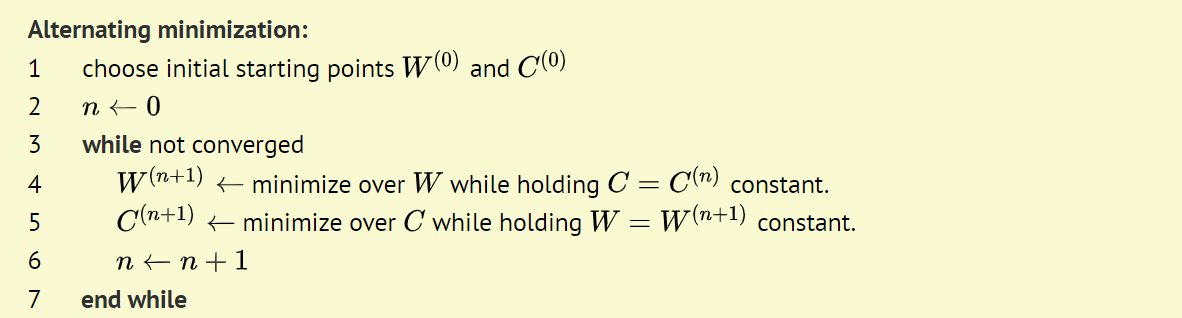</p> </center>

Again, the idea here is that the sub-problems (4) and (5) are easy to optimize because they are convex. It isn’t necessary to minimize the sub-problems to completion, in fact it can work better to take just take alternating gradient steps for each sub-problem.

**Sparse PCA**. If we substitute a L1 norm penalty for the L2 norm regularization we encounter a form of sparse PCA:

\begin{equation}
\begin{aligned}
& \underset{W,C}{\text{minimize}}
& & \lVert \mathbf{X} - W C^T \lVert_F^2 ~+~ \gamma \sum_{i=1}^n \lVert \mathbf{w}_i \lVert_1 ~+~ \gamma \sum_{j=1}^p \lVert \mathbf{c}_j \lVert_1 \\
\end{aligned}
\end{equation}

This problem is similar to LASSO and elastic net regression. Typically, this penalty/regularization choice causes the best $W$ and $C$ to be sparse (i.e. have many zero entries). This can be helpful for interpretation. For example, if we have a gene expression dataset then we may want to limit ourselves so that each component — column of $C$
 — only contains a handful of genes, rather than a large combination of all genes (which can be quite large). This is demonstrated in the figure below from D’Aspremont et al. (2007):

<center> <p>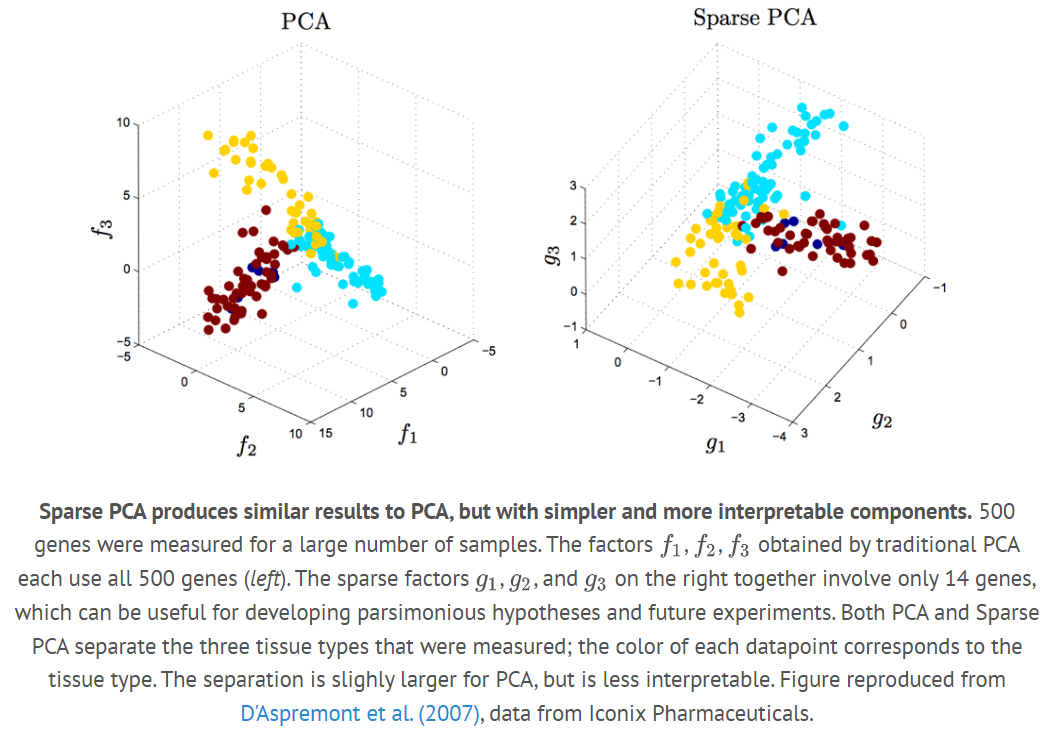</p> </center>

**Non-negative matrix factorization.** Another popular dimensionality technique is non-negative matrix factorization (NMF), which is similar to non-negative least-squares regression. Again, this looks very similar PCA, the only difference being that we constrain/demand each element of $W$ and $C$ to be nonnegative:

\begin{equation}
\begin{aligned}
& \underset{W,C}{\text{minimize}}
& & \lVert \mathbf{X} - W C^T \lVert_F^2 \\
& \text{subject to}
& & W_{ik} \geq 0,~ C_{jk} \geq 0
\end{aligned}
\end{equation}


This typically only makes sense when your data is also nonnegative, $x_{ij} \geq 0$, since the reconstructed estimate for each datapoint is clearly nonnegative when both $W$ and $C$ are nonnegative. Like sparse PCA, NMF can lead to a more interpretable dimensionality reduction since it forces only additive, not subtractive, combinations of the components. (PCA reconstructs the dataset by both additive and subtractive combinations of components.) NMF is an central part of the calcium imaging analysis pipeline recently published by Liam Paninski’s group (Pnevmatikakis et al., 2016).

**Logistic PCA.** We can also replace squared error with different loss functions. For example, suppose you sequence the genomes of $n$  patients and check $p$ nucleotide sites for mutations ($x_{ij}=1$ if patient $i$ has a mutation at site $j$, and $x_{ij}=-1$ if there is not mutation). Because your data is binary you might use logistic PCA, which is similar to logistic regression:

\begin{equation}
\begin{aligned}
& \underset{W,C}{\text{minimize}}
& & \sum_{i=1}^n \sum_{j=1}^p  \log ( 1 + \exp(-x_{ij} \cdot \sum_{k=1}^r W_{ik} C_{jk} )) \\
\end{aligned}
\end{equation}

Why use logistic PCA? When we have binary data, modeling the output as a linear combination of factors/components doesn’t make a whole lot of sense: the data are either $x_{ij} = \{+1,-1\}$, but $\mathbf{w}^T_i \mathbf{c}_j$ could be much larger or smaller than these bounds. For a longer explanation, read up on [when/why to use logistic regression instead of linear regression](https://stats.stackexchange.com/questions/29325/what-is-the-difference-between-linear-regression-and-logistic-regression) — the reasoning is exactly analogous. It is also informative to compare classic to logistic PCA on simulated binary data, as shown in the plot below:

<center> <p>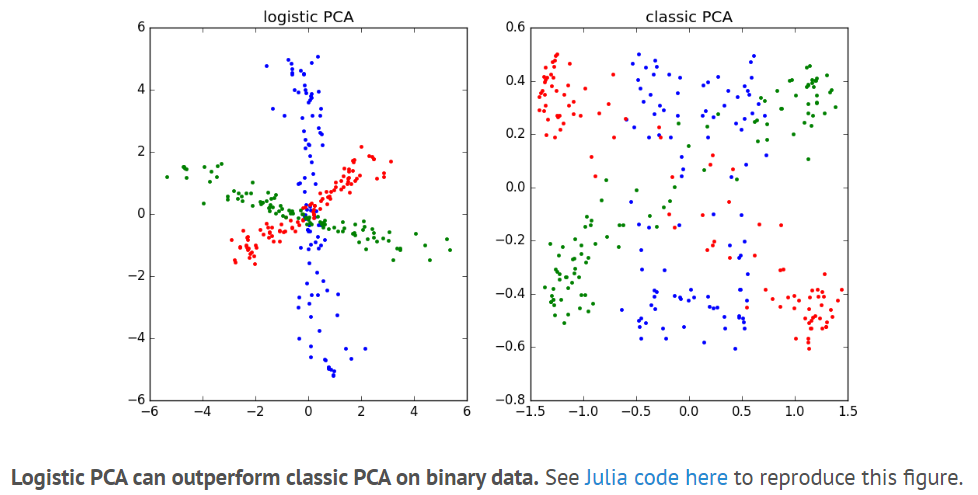</p> </center>

There are many other variations that you can come up with, each of which is tailored to different data types and characteristics:

**Robust PCA.** If you have outliers in your dataset, use the sum of the absolute value of the residuals (L1 loss) or a Huber loss function (Kwak, 2008). There are some alternative formulations of robust PCA, see e.g. Candes et al. (2009) and Netrapalli et al. (2014).

**Poisson PCA and PCA on ordinal data.** See Rennie & Srebro (2005) for some discussion of appropriate loss functions.

**Zero-Inflated dimensionality reduction.** Some datasets, such those from single-cell RNAseq, have more zero entries than would be expected under a Poisson noise model. This can arise from technical variability — mRNA is fragile, and lowly expressed genes have less starting material, leading to “dropout” of lowly expressed genes to zero. Pierson & Yau (2015) develop a model to account for this flavor of noise, and their work can be mapped onto the optimization framework described in this post.

**All of these methods have the same basic flavor:**

- We start with a 2D array of data $X$
- We define some cost function or objective function that measures the fit (e.g. least-squares or logistic loss)
- If we want, we can add terms to the cost function regularize the problem (e.g. to encourage sparsity or enforce nonnegativity)
- We optimize two smaller matrices $W$ and $C^T$ so that their product reconstructs the data as best as possible.
- The optimization problem is biconvex (unless the regularization terms or constraints aren’t convex) suggesting alternating minimization as a reasonable optimization procedure

In the next post we’ll see that this basic procedure extends quite nicely to other data structures. For example, sometimes our data is more naturally represented in a 3D array (i.e. a tensor), rather than a matrix. We can apply similar optimization schemes to reduce the dimensionality of the data in this case.

<a id = "some-things"></a>
## **Some things you maybe didn’t know about PCA**

#### **PCA overfits to noise if** $p>n$ **(i.e. it is an inconsistent estimator of the subspace of maximal variance)**.
When solving linear systems of equations the number of equations must be greater than then number of unknown variables. In linear regression, this means that we need more observations than unknown variables ($n>p$). We’ve seen that PCA is closely related to regression, and so it should come as no big surprise that PCA runs into problems when $p>n$. Intuitively, each dimension/feature has some noise associated with it, and we need more observations than parameters to reliably tease apart the signal from the noise.

One way to potentially get around this problem is to use sparse PCA (Johnston & Lu, 2009), although this assumes that your dataset is well-represented in a sparse basis. Moreover, you shouldn’t blindly assume that L1 regularization will produce the correct sparsity pattern (Su et al., 2015; Advani & Ganguli, 2016).

**There is a very good and simple procedure to determine how many principal components to keep**
A primary motivation behind PCA is to use as few components as possible to reduce the dimensionality of the data we are working with. Thus, we are often interested in truncating PCA — keep only the top $k$ components and throw away the rest. There are at least two reasons for this:

- Truncating gives us a sense of how complex the dataset is. If the top two principal components capture a large majority of variance, then the dataset is more-or-less two-dimensional.[6]

- Truncating denoises the data. The conceptual connection of PCA to regression is again helpful here — PCA is analogous to fitting a smooth curve through noisy data. Similar intuition is given by figure 2 in this blog post, in which a rank-1 approximation gives a smooth, less noisy, representation of the data.

The question then becomes, how do we choose where to truncate? This used to be one of those classic questions with an unsatisfying answer… Basically, eyeball it.

Gavish & Donoho (2014) present a long overdue result on this problem and their answer is surprisingly simple and concrete. Essentially, the optimal[7] procedure boils down to estimating the noise in the dataset, $\sigma$, and then throwing away all components whose singular values are below a specified threshold. **For a square $n \times n$ matrix, this threshold is:**
$$
    \lambda =  \frac{4\sigma\sqrt{n}}{\sqrt{3}}
$$

There is a similar threshold for non-square datasets explained in the paper. As with any theoretical study, the result comes with a few assumptions and caveats,[8] but their work appears robust and useful in practice.

Edit: Thanks to Jonathan Pillow for pointing out a Bayesian alternative outlined here: Minka (2000). [Automatic choice of dimensionality for PCA](https://hd.media.mit.edu/tech-reports/TR-514.pdf)

**PCA becomes non-trivial to solve when data entries are missing**

After thinking about these topics for a while, I found it pretty incredible that PCA works at all. In the first place, it is pretty special any time you can provably and analytically solve a nonconvex optimization problem.

The specialness of PCA breaks down even under pretty mild perturbations. Ilin & Raiko (2010) discuss a nice illustration of this point. Consider the case where some subset of data entries are not observed 
. Even if you keep the ordinary PCA objective function, a number of problems arise:

- There is no analytical solution because the data covariance matrix is nontrivial to estimate
- The objective function contains local minima (unlike in classic PCA, where there are only saddle points and one global minimum). Thus, it is difficult to certify that the output of your optimization problem is true solution to the problem.
- There is no analytical solution even for the bias term, in contrast to classic PCA where the bias equals column-wise mean of the data matrix.

This last one is particularly jarring. It feels so natural to mean-center the data that is easy to forget that this is not always justified. The task of estimating missing data entries is known as matrix completion and is an important problem in the machine learning community (see Netflix Prize, Candes & Recht, 2008). Alternating minimization is a common approach for solving these problems (e.g., Jain et al., 2013).

## **TL;DR**

- PCA finds low-dimensional projections that maximally preserve variance in the data
- This is equivalent to finding a projection that minimizes the projection distance in a least-squares sense
- This second formulation is similar to least-squares regression. Thinking about PCA this way helps because really smart statisticians have spent decades characterizing, generalizing, robustifying regression. Natural extensions of PCA in this framework include:
    - Sparse PCA, similar to LASSO in regression
    - Non-negative matrix factorization, similar to non-negative least squares
    - Logistic PCA for binary data, similar to Logistic regression
    - A variety of tensor decompositions
- PCA is not always easy:
    - When there are fewer replicates/samples than measured features/variables ($p>n$) PCA is an inconsistent estimator. You need to regularize the problem somehow.
    - When there are missing data entries PCA is provably NP-hard.
- How do you choose the number of principal components to keep?
    - It isn’t as necessarily hard as you think. Gavish & Donoho (2014) describe an easy procedure to truncate all components below a threshold based on the level of noise in your data.

## **Further Reading**
- Udell et al. (2015). Generalized Low-Rank Models. arxiv preprint
- Tipping & Bishop (1999). Probabilistic principal component analysis. Journal of the Royal Statistical Society: Series B
- Ilin & Raiko (2010). Practical Approaches to Principal Component Analysis in the Presence of Missing Values. Journal of Machine Learning Research
- Gordon (2002). Generalized2 Linear2 Models. NIPS
- Cunningham & Ghahramani (2015) Linear dimensionality reduction: survey, insights, and generalizations Journal of Machine Learning Research
- Burges (2009). Dimension Reduction: A Guided Tour. Foundations and Trends in Machine Learning

#### **Footnotes**
[1]()
